In [1]:
import logging
import os
import torch
from PIL import Image
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch import optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchmetrics.classification import MulticlassJaccardIndex

USE_WANDB = False # enable wandb, TODO: read wandb docs and learn how to use it for real 
%env WANDB_SILENT=True
WANDB_PROJECT_NAME = "unet-from-scratch"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline

env: WANDB_SILENT=True


In [2]:
if USE_WANDB:
    import wandb
    wandb.login(key=os.environ["WANDB_API_KEY"], relogin=True, force=True)

In [3]:
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)

# https://www.tutorialexample.com/fix-python-logging-module-not-writing-to-file-python-tutorial/
for handler in logging.root.handlers:
    logging.root.removeHandler(handler)

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s',
                   handlers=[logging.FileHandler("logfile.log", mode="a"), stream_handler])

In [4]:
class CarvanaImageMaskingChallangeDataset(Dataset):
    PATH_TO_IMGS = "/home/jurica/Desktop/projekt/Pytorch-UNet/data/imgs"
    PATH_TO_MASKS = "/home/jurica/Desktop/projekt/Pytorch-UNet/data/masks"
    IMG_EXT = ".jpg"
    MASK_EXT = "_mask.gif"

    # black: background
    # white: car
    mask_values = [[0,0,0], [255,255,255]]
    
    def __init__(self):
        assert len(os.listdir(self.PATH_TO_IMGS)) == len(os.listdir(self.PATH_TO_MASKS))

        # Each car has exactly 16 images, each one taken at different angles.
        # Each car has a unique id and images are named according to id_01.jpg, id_02.jpg … id_16.jpg.
        self.img_ids = [os.path.splitext(img)[0] for img in os.listdir(self.PATH_TO_IMGS)]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_name = self.img_ids[idx] + self.IMG_EXT
        img_path = os.path.join(self.PATH_TO_IMGS, img_name)

        mask_name = self.img_ids[idx] + self.MASK_EXT
        mask_path = os.path.join(self.PATH_TO_MASKS, mask_name)
        
        img_raw = Image.open(img_path)
        mask_raw = Image.open(mask_path)
        
        img, mask = self.preprocess(img_raw, mask_raw)
        
        return {"image": img, "mask": mask}

    @classmethod
    def get_mask_values(cls):
        return cls.mask_values

    def preprocess(self, img, mask):
        img = np.asarray(img.resize((572,572), resample=Image.Resampling.BICUBIC))
        # convert to RGB for black&white mask
        mask = np.asarray(mask.resize((572,572), resample=Image.Resampling.BICUBIC).convert("RGB")) 
        
        # create ground truth for cross entropy loss
        mask_with_classes = np.zeros((572, 572), dtype=np.int64)
        for c, mask_class_pixel_value in enumerate(self.mask_values):
            # (img == mask_class_pixel_value) creates new np array, (img==mask_class_pixel_value).shape == img.shape
            # (img==mask_class_pixel_value)[i] -> [True, False, True], 
            # (comparing corresponding pixel components with corresponding mask_class_pixel_value components)
            # (img==mask_class_pixel_value).all(-1) creates new np array
            # x.all(-1) checks if every element of x along -1 (last) dimension is True
            # (img==mask_class_pixel_value).all(-1).shape == (H, W)
            # in this case, check which (img==mask_class_pixel_value)[i] is equal to [True, True, True] (pixel matches class mask_class_pixel_value)
            
            # set pixel class to be c for every pixel in original mask image
            # if pixel values along all channels (-1) correspondingly match values of class c
            mask_with_classes[(mask == mask_class_pixel_value).all(-1)] = c
        
        # swap color axis
        # numpy image: H x W x C
        # torch image: C x H x W
        img = img.transpose((2, 0, 1))

        # normalize pixels?
        img = img / 255.0

        img_tensor = torch.tensor(img.copy()).to(dtype=torch.float32)
        
        mask_tensor = torch.tensor(mask_with_classes.copy()).to(dtype=torch.long) # Cross entropy loss requires target to be LongTensor
        
        return img_tensor, mask_tensor

In [5]:
class EncoderBlock(nn.Module):
    def __init__(self, input_volume_channels, output_volume_channels):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(input_volume_channels, output_volume_channels, kernel_size=3),
            nn.BatchNorm2d(output_volume_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(output_volume_channels, output_volume_channels, kernel_size=3),
            nn.BatchNorm2d(output_volume_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.seq(x)

class DecoderBlock(nn.Module):
    def __init__(self, input_volume_channels, output_volume_channels):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(input_volume_channels, output_volume_channels, kernel_size=2, stride=2)
        self.double_conv = EncoderBlock(input_volume_channels, output_volume_channels)
    
    def forward(self, x, encoder_feature_map):
        deconv_ret = self.deconv(x)

        diffInHeight = encoder_feature_map.size()[2] - deconv_ret.size()[2]
        diffInWidth = encoder_feature_map.size()[3] - deconv_ret.size()[3]
        
        # [padding_left, padding_right, padding_top, padding_bottom]
        # now deconv_ret.shape == encoder_feature_map.shape
        deconv_ret = nn.functional.pad(deconv_ret, [diffInWidth // 2, diffInWidth - diffInWidth // 2,
                        diffInHeight // 2, diffInHeight - diffInHeight // 2])

        # concat along "channel" dimension, dim=1 because dim=0 -> N (batch size) 
        concat_x = torch.cat([encoder_feature_map, deconv_ret], dim=1)

        return self.double_conv(concat_x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_block1 = EncoderBlock(3, 64)      
        self.enc_block2 = EncoderBlock(64, 128)
        self.enc_block3 = EncoderBlock(128, 256)
        self.enc_block4 = EncoderBlock(256, 512)
        self.enc_block5 = EncoderBlock(512, 1024)

        self.dec_block1 = DecoderBlock(1024, 512)
        self.dec_block2 = DecoderBlock(512, 256)
        self.dec_block3 = DecoderBlock(256, 128)
        self.dec_block4 = DecoderBlock(128, 64)

        self.final_output = nn.Conv2d(64, 2, kernel_size=1)
        
    def forward(self, x):
        
        enc_out1 = self.enc_block1(x)
        pooled_enc_out1 = self.max_pool(enc_out1)
        
        enc_out2 = self.enc_block2(pooled_enc_out1)
        pooled_enc_out2 = self.max_pool(enc_out2)
        
        enc_out3 = self.enc_block3(pooled_enc_out2)
        pooled_enc_out3 = self.max_pool(enc_out3)
        
        enc_out4 = self.enc_block4(pooled_enc_out3)
        pooled_enc_out4 = self.max_pool(enc_out4)
        
        enc_out5 = self.enc_block5(pooled_enc_out4)

        dec_out1 = self.dec_block1(enc_out5, enc_out4)
        dec_out2 = self.dec_block2(dec_out1, enc_out3)
        dec_out3 = self.dec_block3(dec_out2, enc_out2)
        dec_out4 = self.dec_block4(dec_out3, enc_out1)

        return nn.functional.interpolate(self.final_output(dec_out4), size=572, mode="bicubic")

In [6]:
 def iou(masks_pred, masks):
    # resulting tensor of shape (N, masks_predH, masks_predW)
    # each element of resulting tensor is index of value that is max at given position across channel dimension
    # e.g., if we have 2 channels (2 classes) then values of resulting tensor are in range [0,1]
    most_certain_pred_values = masks_pred.argmax(dim=1)
    
    # one_hot appends number of classes as last dimension
    # tensor of shape (N, H, W) becomes (N, H, W, n_classes), have to correct it to (N, C, H, W)
    masks_pred = nn.functional.one_hot(most_certain_pred_values, len(CarvanaImageMaskingChallangeDataset.get_mask_values())).permute(0, 3, 1, 2).float()
    
    masks = nn.functional.one_hot(masks, len(CarvanaImageMaskingChallangeDataset.get_mask_values())).permute(0, 3, 1, 2).float()
        
    _iou = MulticlassJaccardIndex(num_classes=2, average="macro").to(device=device) # Calculate statistics for each label and average them
    return _iou(masks_pred, masks).item()

def train_model(model, device, epochs, batch_size, learning_rate, weight_decay, momentum, gradient_clipping, val_percent):
    dataset = CarvanaImageMaskingChallangeDataset()

    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], torch.Generator().manual_seed(1337))

    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True, shuffle=False, drop_last=True)

    #optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, foreach=True)
    
    optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay, fused=True)
    learning_rate = 0.001 # default Adam learning rate
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5) # maximize IOU
    criterion = nn.CrossEntropyLoss() # default reduction: the weighted mean of the output of LogSoftmax is taken


    if USE_WANDB:
        experiment = wandb.init(project=WANDB_PROJECT_NAME)
        experiment.config.update(
        dict(epochs=epochs, 
             batch_size=batch_size,
             
             n_train=n_train,
             n_val=n_val,
             
             learning_rate=learning_rate,
             weight_decay=weight_decay,
             momentum=momentum,
             gradient_clipping=gradient_clipping,
             
             val_percent=val_percent)
        )

    logging.info(
        f"""Starting training:
        Epochs:              {epochs}
        Batch size:          {batch_size}

        Training set size:   {n_train}
        Validation set size: {n_val}
        
        Learning rate:       {learning_rate}
        Weight decay:        {weight_decay}
        Momentum:            {momentum}
        Gradient clipping:   {gradient_clipping}
        """
    )

    # During training, the global_step is updated every time a batch is processed
    # When logging training metrics to wandb, the global_step is used as the x-axis to indicate this
    global_step = 0
    
    for epoch in range(1, epochs+1):
        model.train() # for BatchNorm

        with tqdm(total=n_train, desc=f"Epoch {epoch}/{epochs}", unit="img") as progress:
            for batch in train_loader:
                images = batch["image"].to(device=device, memory_format=torch.channels_last)
                masks = batch["mask"].to(device=device)

                masks_pred = model(images)

                loss = criterion(masks_pred, masks)
                
                optimizer.zero_grad(set_to_none=True)

                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping) # can't hurt?

                optimizer.step()

                # update number of remaining images
                progress.update(images.shape[0])
                progress.set_postfix(**{"loss (batch)" : loss.item()})
                global_step += 1

                if USE_WANDB:
                    experiment.log({
                    "train loss": loss.item(),
                    "step": global_step,
                    "epoch": epoch
                    })
                
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        if USE_WANDB:
                            histograms = {}
                            for tag, value in model.named_parameters():
                                tag = tag.replace('/', '.')
                                if not (torch.isinf(value) | torch.isnan(value)).any():
                                    histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                                if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                    histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())
                        
                        val_score = 0
                        with torch.inference_mode(): # disable gradient calculation and other vudu
                            model.eval() # for BatchNorm
                            
                            iou_score = 0
    
                            # leave=True? Position=0?
                            for batch in tqdm(val_loader, total=n_val, desc="Validation", unit="batch", position=0, leave=True):
                                images = batch["image"].to(device=device, memory_format=torch.channels_last)
                                masks = batch["mask"].to(device=device)
    
                                masks_pred = model(images)

                                iou_score += iou(masks_pred, masks)
                            
                            model.train()
                            val_score = iou_score / max(n_val, 1)
                            logging.info(f"IOU score: {val_score}")
                        scheduler.step(val_score)

                        if USE_WANDB:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation IOU': iou_score,
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })                     
        
        state_dict = model.state_dict()
        torch.save(state_dict, "/home/jurica/Desktop/projekt/pokusaj/checkpoints/checkpoint_epoch{}.pth".format(epoch))
        logging.info(f"Checkpoint {epoch} saved!")

    if USE_WANDB:
        experiment.finish()    

In [ ]:
#torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available() == True

model = UNet()
model = model.to(device=device, memory_format=torch.channels_last)

train_model(
    model=model,
    device=device,
    epochs=3,
    batch_size=1,
    learning_rate=1e-5,
    weight_decay=1e-8,
    momentum=0.999,
    gradient_clipping=1.0,
    val_percent=0.1
)


INFO: Starting training:
       Epochs:              3
       Batch size:          1

       Training set size:   4565
       Validation set size: 507
       
       Learning rate:       0.001
       Weight decay:        1e-08
       Momentum:            0.999
       Gradient clipping:   1.0
       
Validation: 100%|██████████████████████████| 507/507 [00:39<00:00, 12.81batch/s]
INFO: IOU score: 0.8932622394853325
Validation: 100%|██████████████████████████| 507/507 [00:36<00:00, 13.82batch/s]
INFO: IOU score: 0.9797208322105558
Validation: 100%|██████████████████████████| 507/507 [00:36<00:00, 13.85batch/s]
INFO: IOU score: 0.9259961474341518
Validation: 100%|██████████████████████████| 507/507 [00:39<00:00, 12.99batch/s]
INFO: IOU score: 0.9039142315204327
Validation: 100%|██████████████████████████| 507/507 [00:38<00:00, 13.29batch/s]
INFO: IOU score: 0.9328345683434541
Epoch 1/3: 100%|██████| 4565/4565 [20:56<00:00,  3.63img/s, loss (batch)=0.0158]
INFO: Checkpoint 1 saved!
Validat

In [8]:
def mask_to_image(mask, mask_values):
    width = mask.shape[-2]
    height = mask.shape[-1]
    number_of_classes = len(mask_values)

    out = np.zeros((height, width, 3), dtype=np.uint8)
    
    # along channel axis
    # return index c where value is True
    mask = np.argmax(mask, axis=0) # for every pixel position, find the class of the pixel (that net classified it in)
   
    # for every class c
    for c, mask_value in enumerate(mask_values):
        # set pixel value in output to mask_value
        # for every pixel that is located at position where predicted class == c
        # for every pixel, mask contains indices of a class that net predicted given pixel is located in
        out[mask == c] = mask_value
        
    return Image.fromarray(out)

IOU:99.51%


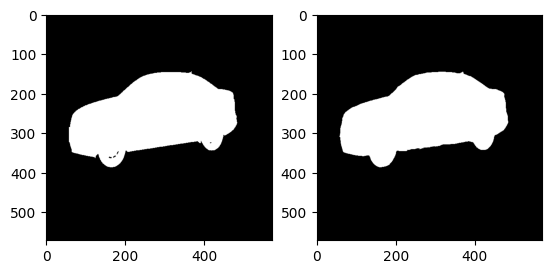

In [9]:
# TODO: make this less ugly 
def predict(model, device, path_to_image, path_to_mask, out_thresh=0.5): 
    state_dict = torch.load("/home/jurica/Desktop/projekt/pokusaj/checkpoints/checkpoint_epoch3.pth", map_location=device)
    model.load_state_dict(state_dict)

    img_raw = Image.open(path_to_image)
    img = np.asarray(img_raw.resize((572,572), resample=Image.Resampling.BICUBIC))
    img_n = img.transpose((2, 0, 1))
    img_n = img_n / 255.0
    img_tensor = torch.tensor(img_n.copy()).float()
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(device=device)#, dtype=torch.float32)


    mask_raw_r = Image.open(path_to_mask)
    mask_raw = np.asarray(mask_raw_r.resize((572,572), resample=Image.Resampling.BICUBIC).convert("RGB")) 
    # create ground truth for cross entropy loss
    masks_true = np.zeros((572, 572), dtype=np.int64)
    mask_values = CarvanaImageMaskingChallangeDataset.get_mask_values()
    for c, mask_class_pixel_value in enumerate(mask_values):
        masks_true[(mask_raw == mask_class_pixel_value).all(-1)] = c

    masks_true = torch.tensor(masks_true.copy()).long()
    masks_true = masks_true.unsqueeze(0)
    masks_true = masks_true.to(device=device)

    mask = None
    net_output = None

    with torch.inference_mode(): # disable gradient calculation
        model.eval()
        net_output = model(img_tensor).cpu()
        
        # apply the sigmoid activation to get predictions in the range [0, 1]
        # create new mask array, mask[i] = True if output probability > out_tresh 
        # if mask[i] = True then pixel[i] is in class c where c is channel where mask[i] = True
        mask = torch.sigmoid(net_output) > out_thresh
    
        # .long() to convert True/False in 1/0
        mask = mask[0].long().squeeze().numpy()
        
    
    print(f"IOU:{round(iou(net_output.to(device=device), masks_true)*100, 2)}%")

    return mask_raw, mask_to_image(mask, CarvanaImageMaskingChallangeDataset.get_mask_values())

mask_raw, mask_pred = predict(model, 
                                device, 
                                path_to_image="/home/jurica/Desktop/projekt/Pytorch-UNet/data/test_img/0cdf5b5d0ce1_04.jpg",
                                path_to_mask="/home/jurica/Desktop/projekt/Pytorch-UNet/data/test_mask/0cdf5b5d0ce1_04_mask.gif"
                               )

f, axarr = plt.subplots(1,2)
axarr[0].imshow(mask_raw)
axarr[1].imshow(mask_pred)


In [13]:
def plot_img_and_mask(img, mask):
    classes = mask.max() + 1
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    for i in range(classes):
        ax[i + 1].set_title(f'Mask (class {i + 1})')
        ax[i + 1].imshow(mask == i)
    plt.xticks([]), plt.yticks([])
    plt.show()